In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Input , Dense , Flatten , AveragePooling2D , MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import cv2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

#   i = vgg.input
#   x = i
#   for layer in vgg.layers:
#     if layer.__class__ == MaxPooling2D:
#       # replace it with average pooling
#       x = AveragePooling2D()(x)
#     else:
#       x = layer(x)

  return new_model

In [ ]:
def vgg16(shape , layer_num):
    vgg = VGG16_AvgPool(shape)
    if layer_num > 0 and layer_num <= 19 :
        model = Model(vgg.input , vgg.layers[layer_num].output)
        return model
    else:
        return vgg

In [ ]:
def unpreprocess(img):
    img[... , 0] += 103.939
    img[... , 1] += 116.779
    img[... , 2] += 126.68
    img = img[... , ::-1]

    return img

In [ ]:
def scale_img(img):
    img = img - img.min()
    img = img / img.max()

    return img

In [ ]:
img = plt.imread("elephant image.jpg")

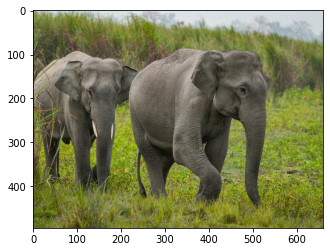

In [ ]:
plt.imshow(img)

In [ ]:
x = img.copy()
x = np.expand_dims(x , axis = 0)
x = preprocess_input(x)
batch_shape = x.shape
shape = x.shape[1:]

### create model

In [ ]:
content_model = vgg16(shape , 13)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
content_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 495, 660, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 495, 660, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 495, 660, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 247, 330, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 247, 330, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 247, 330, 128)     147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 123, 165, 128)     0     

### make target

In [ ]:
target = K.variable(content_model.predict(x))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Mean squared error 

In [ ]:
loss  = K.mean(K.square(target - content_model.output))

### gradients

In [ ]:
grads = K.gradients(loss , content_model.input)

### get loss and gradients

In [ ]:
get_loss_and_grads = K.function(
                     inputs = [content_model.input] , 
                     outputs = [loss] + grads
                    )

In [ ]:
def loss_and_Grads_wrapper(x_vec):
    loss , grads = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return loss.astype(np.float64) , grads.flatten().astype(np.float64)

In [ ]:
def minimize_RMS_Momentum(x0 , learning_rate = 0.001 ,epochs = 1500 , return_loss = True):
    cache = 0
    dW = 0
    mu = 0.9
    decay_rate = 0.999
    eps = 1e-10
    w = x0
    losses = []
    shape = batch_shape
    for i in range(epochs):
        l , g = get_loss_and_grads(w)
         
        cache = decay_rate*cache + (1 - decay_rate)*g*g
        dW = (mu * dW) - learning_rate* (g / np.sqrt(cache + eps))

        w += dW
        w = np.clip(w , -127 , 127) 
        
        losses.append(l)

        if i%50 == 0:
            print(f"epochs - {i} ---- loss - {l}")
            img = w.copy()
            # img = unpreprocess(img.reshape(*shape))
            final_img = scale_img(img)
            # final_img = final_img.reshape(shape)
            plt.imshow(final_img[0])
            plt.show()

    if return_loss:
        return losses , w
    return w

In [ ]:
x = np.random.randn(*batch_shape)
losses , x = minimize_RMS_Momentum(x0 = x  , epochs = 500)
final_img1 = scale_img(unpreprocess(x.reshape(*batch_shape)))

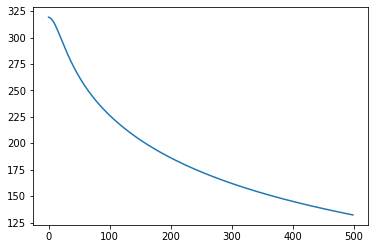

In [ ]:
plt.plot(losses)

In [ ]:
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    w = x.copy()
    final_img = scale_img(unpreprocess(w.reshape(*batch_shape)))
    x , l , _ = fmin_l_bfgs_b(
                func = loss_and_Grads_wrapper,
                x0 = x,
                maxfun = 20
                )
    losses.append(l)
    x = np.clip(x , -127 , 127)
    print(i , l)
    plt.imshow(final_img[0])   
    plt.show()

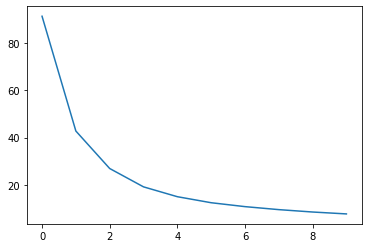

In [ ]:
plt.plot(losses)

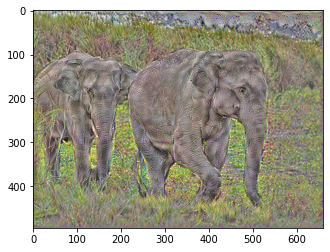

In [ ]:
plt.imshow(final_img[0])